In [187]:
import torch
import pyro.distributions as dist
import pyro
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import Predictive, infer_discrete, TraceEnum_ELBO, config_enumerate, SVI
from pyro.infer.autoguide import AutoNormal, AutoDelta
from pyro.ops.indexing import Vindex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
print(pyro.__version__)

1.8.2+2e3bd02


In [177]:
initial_probs = torch.tensor([0.5, 0.5])
transition_matrix = torch.tensor([[0.95, 0.05], 
                               [0.10, 0.90]])
emission_probs = torch.tensor([[1/6,  1/6,  1/6,  1/6,  1/6,  1/6], # fair die
                            [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]])  # loaded die

print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: torch.Size([2, 2])
B.shape: torch.Size([2, 6])


In [178]:
hmm = dist.DiscreteHMM(
    initial_logits=torch.logit(initial_probs),
    transition_logits=torch.logit(transition_matrix),
    observation_dist=dist.Categorical(emission_probs),
    duration=50
    )

emission = hmm.sample()

In [179]:
@config_enumerate
def model_1(xs):
    # sample an inital latent state
    z = pyro.sample('z_init', dist.Categorical(initial_probs))
    states = []
    for t, y in pyro.markov(enumerate(xs)):
        z = pyro.sample(
            f'z_{t}', 
            dist.Categorical(Vindex(transition_matrix)[..., z, :]),
            )
        states.append(z)
        pyro.sample(
            f"y_{t}", 
            dist.Categorical(Vindex(emission_probs)[..., z, :]),
            obs=xs[t]
            )

    return states

In [193]:
hmm_guide = AutoDelta(
    pyro.poutine.block(
        model_1, 
        expose="z_init",
        hide_fn=lambda msg: msg["name"].startswith("z_"))
    )

elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model_1, hmm_guide, emission)

81.92050170898438

In [202]:
latent_states = torch.Tensor(elbo.sample_posterior(model_1, hmm_guide, emission))

In [181]:
# nuts_kernel = NUTS(model_1, jit_compile=True, ignore_jit_warnings=True)
# mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=100)
# mcmc.run(emission)

In [182]:
#pyro.render_model(model_1, (emission,), render_distributions=True)

In [183]:
serve = infer_discrete(model_1, first_available_dim=-1, temperature=1)
latent_states = torch.Tensor(serve(emission))

In [184]:
one_hot = torch.nn.functional.one_hot(emission, 6).T

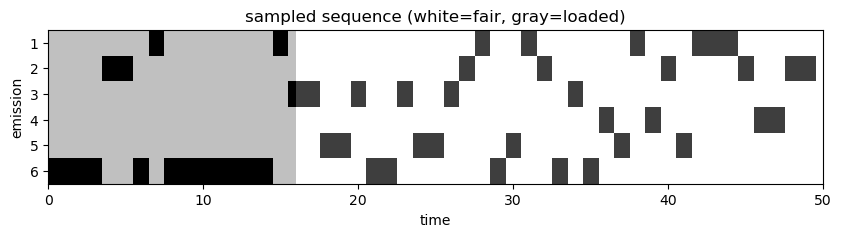

In [203]:
plt.figure(figsize=(10, 2))
plt.imshow(one_hot, aspect="auto", interpolation="none", cmap="Greys")
plt.imshow(
    latent_states[None, :], extent=(0, 50, 6-.5, -.5), 
    interpolation="none", aspect="auto", cmap="Greys", alpha=0.25
    )
plt.xlabel("time")
plt.ylabel("emission")
plt.yticks(np.arange(6), np.arange(6) + 1)
plt.title("sampled sequence (white=fair, gray=loaded)");